#### This notebook shows how to read the M4Raw dataset and apply some simple transformations to the data.
#### Refer to fastMRI

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import os

The M4Raw dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the M4Raw dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [3]:
data_folder = '/raid/SZTU200H5/'; # please change this to your data folder
file_name = os.path.join(data_folder, '2022061003_T201.h5')
hf = h5py.File(file_name)

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 121.5855875063667, 'patient_id': '88448eec274d9248d1a2487a8548ee41'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

In [5]:
volume_kspace = hf['kspace'][()]
print('Kspace shape:',volume_kspace.shape)
out = hf['reconstruction_rss'][()]
print('reconstruction rss shape:',out.shape)

Kspace shape: (18, 4, 256, 256)
reconstruction rss shape: (18, 256, 256)


In [6]:
slice_kspace = volume_kspace[8] # Choosing the 8-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [7]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

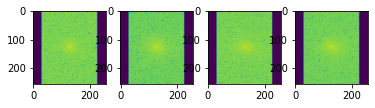

In [8]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 1, 2, 3])  # This shows coils 0, 1, 2 and 3

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [9]:
import fastmri
from fastmri.data import transforms as T

In [10]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

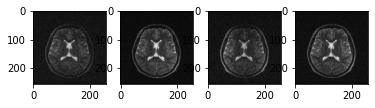

In [11]:
show_coils(slice_image_abs, [0, 1, 2, 3], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [12]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

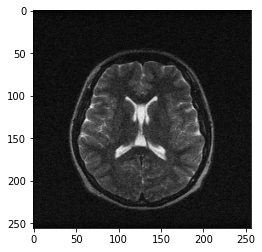

In [13]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [14]:
from fastmri.data.subsample import EquispacedMaskFractionFunc
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[3])  # Create the mask function object

In [15]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [16]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

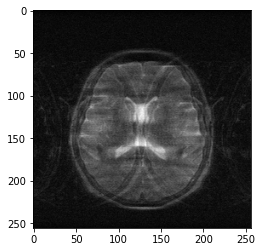

In [17]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Let's inspect the header

In [18]:
header = hf['ismrmrd_header'][()].decode()

In [19]:
print(header)

<ns0:ismrmrdHeader xmlns:ns0="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">
   <ns0:studyInformation>
      <ns0:studyUID>2022061003</ns0:studyUID>
      <ns0:studyTime>165418</ns0:studyTime>
   </ns0:studyInformation>
   <ns0:measurementInformation>
      <ns0:measurementID>2022061003_FSE01</ns0:measurementID>
      <ns0:seriesInstanceUID>1.2.156.110001.1.1001.5694.2022061003.20220610.14</ns0:seriesInstanceUID>
      <ns0:patientPosition>HFS</ns0:patientPosition>
      <ns0:protocolName>FSE(Sat) 5mmT--V</ns0:protocolName>
      <ns0:frameOfReferenceUID>1.2.156.110001.1.2022.6.10.17</ns0:frameOfReferenceUID>
   </ns0:measurementInformation>
   <ns0:acquisitionSystemInformation>
      <ns0:systemVendor> XinGaoYi Medical Equipment Co.,Ltd.</ns0:systemVendor>
      <ns0:systemModel>XGY OPER-0.3</ns0:systemModel>
      <ns0:systemFieldStrength_T>0.3</ns0:systemFieldStrength_T>
      <ns0:ac

let's look at how to use the multiple repetitions

In [20]:
import xmltodict
header_dict = xmltodict.parse(header)

In [21]:
singlenex_img = out.copy()
multinex_img = out;
# you can find the info of other repetitions directly in the header.
for other_rep in header_dict['ns0:ismrmrdHeader']["ns0:repetitionInformation"]['ns0:repetitionLabel']:
    with h5py.File(os.path.join(data_folder, other_rep['ns0:MeasurementID']+'.h5')) as hf:
        multinex_img += hf['reconstruction_rss'][()]

Text(0.5, 1.0, 'single repetition VS multi-repetition averaged')

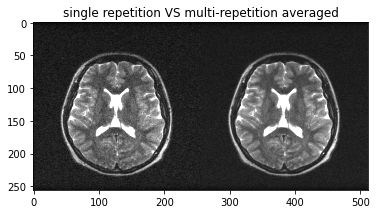

In [22]:
plt.imshow(np.concatenate((singlenex_img[8], multinex_img[8]/3), axis=1), cmap='gray', vmax=60)
plt.title('single repetition VS multi-repetition averaged')

Note that in the above image, the multi-reptition (NEX) averaged image has higher SNR (theoretically 1.7x) than the single-repetition image